# Data Challenge 4

**L'objectif est d'appliquer des modèles d'analyse prédictive sur des logs de parties en 1vs1 de StarCraft2, et de juger la capacité à entraîner un modèle à prédire le vainqueur d'un match particulier.**


Je me suis focalisé sur 2 approches:

* Etant guidés par les résultats (victoire ou défaite du joueur p1 pour chaque partie, on est dans un cas clair **d'apprentissage supervisé**, et j'ai testé différents algorithmes disponibles dans la librairie sklearn de Python. 


* Le nombre de colonnes (features) peut être réduit, en identifiant les caractéristiques les plus importantes ou celles qui décrivent la même information (collinéaire). La diminution de la dimensionnalité du jeu de données vise à :

    * **Tester les meilleurs jeux d'hyperparamètres pour chaque modèle**, ce qui est coûteux sur le jeu complet
    
    * **Tenter d'appliquer des modèles de collection**, et restreindre le nombre de variable à un jeu sur lequel il
     est possible de réfléchir et dégager des axes forts (par exemple : quelle caractéristique le joueur peut améliorer pour gagner plus souvent ? Quelles corrélations entre les caractéristiques ?


## Sommaire

1. Import des données
2. Type des colonnes, proportions de données manquantes, par quoi les remplacer ?
3. préparation d'un jeu "complet" et d'un jeu "light"
    1. Diagramme de corrélation
    2. PCA et Explained Variance
4. Modèles d'apprentissage supervisé
    1. Cross validation
    2. Normalisation
    3. Optimisation des algorithmes (jeu "light")
    4. Test sur les deux jeux
    

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.decomposition import PCA # Principal Component Analysis module
from sklearn.cluster import KMeans # KMeans clustering 
import matplotlib.pyplot as plt # Python defacto plotting library
import seaborn as sns # More snazzy plotting library
%matplotlib inline 

In [2]:
df = pd.read_csv("sc2_dataset_lt_5mins.csv")

Analysons cet ensemble de données. Texte ou numérique ? Proportion de données manquantes ?
Que faire des données manquantes ? Supprimer les colonnes, les remplacer par des zeros, ou la médiane ?

In [3]:
# 328 colonnes
df.head()

,_p1_win_game,game_length,p1_APM,p1_APM_wo_select,p1_Archon,p1_Armory,p1_Assimilator,p1_Auto_Turret,p1_Baneling_Nest,p1_Banshee,...,p2_min_distance_from_opponent,p2_nb_scooting,p2_selected_hotkeys,p2_spent_gas,p2_spent_minerals,p2_timing_1st_scooting,p2_to_Orbital_Command_Command_Center,p2_to_Planetary_Fortress_Command_Center,p2_to_Warp_Gate_Gateway,p2_unit_types
0,0,505.525072,253.755960,117.501591,NaN,NaN,NaN,NaN,NaN,NaN,...,1.326082,126,650,125,5625,45.788680,NaN,NaN,NaN,5
1,1,808.316816,409.814560,184.973045,NaN,NaN,NaN,NaN,1.0,NaN,...,2.195000,34,847,5775,26000,117.381424,3.0,NaN,NaN,7
2,1,615.327680,119.058515,50.509673,NaN,NaN,NaN,NaN,1.0,NaN,...,0.701632,124,2,1200,7275,475.345144,NaN,NaN,1.0,3
3,1,447.150144,283.797292,108.285775,NaN,NaN,2.0,NaN,NaN,NaN,...,109.445248,0,83,0,10100,NaN,2.0,NaN,NaN,2
4,1,693.732336,110.532544,56.996046,NaN,NaN,NaN,NaN,NaN,NaN,...,1.357620,62,24,3350,12550,631.703336,NaN,NaN,NaN,4


In [4]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34534 entries, 0 to 34533
Data columns (total 328 columns):
_p1_win_game                                    34534 non-null int64
game_length                                     34534 non-null float64
p1_APM                                          34534 non-null float64
p1_APM_wo_select                                34534 non-null float64
p1_Archon                                       4 non-null float64
p1_Armory                                       6465 non-null float64
p1_Assimilator                                  11096 non-null float64
p1_Auto_Turret                                  473 non-null float64
p1_Baneling_Nest                                5997 non-null float64
p1_Banshee                                      2340 non-null float64
p1_Barracks                                     10861 non-null float64
p1_Battlecruiser                                316 non-null float64
p1_Building_Attack                              110

In [5]:
# Check columns format : String or numeric
str_list = [] 
for colname, colvalue in df.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = df.columns.difference(str_list)  
len(num_list)
# Only numeric values

328

# Proportion of NaN values ?

In [6]:
def countNaNValues (df):
    """
    Return a list with the number of NaN values in each column 
    """
    
    # List of all features
    df_list = df.columns.values.tolist()
    NaN_list = []
    for feature in df_list:
        NaN_list.append(df[feature].isnull().sum().sum())
    
    return NaN_list



def countNaNRate(df, colName) :
    """
    Return a list of 10 items
    with how many columns have more than 0 to 90 %
    of NaN values
    
    """
    
    NaN_list = countNaNValues(df)
    NaN_rate =[]
    df_list = df.columns.values.tolist()
    
    for j in range(10):
        count = 0
        for i in range(len(df_list)):
            if (NaN_list[i]>0.1*j*len(df[colName])):
                count +=1  
        NaN_rate.append(count)
    return NaN_rate


In [7]:
NaN_rate = countNaNRate(df, "_p1_win_game")
NaN_rate
# 216/328 columns with more than 80 % NaN values
# 32/328 columns with less than 10 % NaN values 

[304, 296, 296, 296, 296, 296, 296, 255, 216, 157]

In [8]:
# Light dataset :  only these 32 columns    
NaN_list = countNaNValues(df)
features = df.columns.values.tolist()
toErase = []
for i in range(len(features)):
    # 90 % of non NaN values 
    if (NaN_list[i]>0.1*len(df._p1_win_game)):
        toErase.append(features[i])
        
df_light = df.drop(toErase, axis=1)
len(df_light.columns)

32

In [9]:
# Change NaN values to zero (more meaning than median)
df = df.fillna(value=0, axis=1) #(328 columns)
df_light = df_light.fillna(value=0, axis=1) #(32 columns)

In [10]:
# As columns are the same for most of the columns, decrease columns number by feature = p1_feature - p2_feature  
# only for df_light
colnames = df_light.columns.values

# sub_lists for each player 
p1_colnames = [name[3:] for name in colnames if "p1" in name]
p2_colnames = [name[3:] for name in colnames if "p2" in name]
colnames = [name for name in p1_colnames if name in p2_colnames ]
print len(colnames)
# 15 dimensions

15


In [11]:
colnames

['APM',
 'APM_wo_select',
 'assigned_hotkeys',
 'building_types',
 'collected_gas',
 'collected_minerals',
 'max_distance_from_opponent',
 'mean_distance_from_opponent',
 'min_distance_from_opponent',
 'nb_scooting',
 'selected_hotkeys',
 'spent_gas',
 'spent_minerals',
 'timing_1st_scooting',
 'unit_types']

In [12]:
df_light.columns.values

array(['_p1_win_game', 'game_length', 'p1_APM', 'p1_APM_wo_select',
       'p1_assigned_hotkeys', 'p1_building_types', 'p1_collected_gas',
       'p1_collected_minerals', 'p1_max_distance_from_opponent',
       'p1_mean_distance_from_opponent', 'p1_min_distance_from_opponent',
       'p1_nb_scooting', 'p1_selected_hotkeys', 'p1_spent_gas',
       'p1_spent_minerals', 'p1_timing_1st_scooting', 'p1_unit_types',
       'p2_APM', 'p2_APM_wo_select', 'p2_assigned_hotkeys',
       'p2_building_types', 'p2_collected_gas', 'p2_collected_minerals',
       'p2_max_distance_from_opponent', 'p2_mean_distance_from_opponent',
       'p2_min_distance_from_opponent', 'p2_nb_scooting',
       'p2_selected_hotkeys', 'p2_spent_gas', 'p2_spent_minerals',
       'p2_timing_1st_scooting', 'p2_unit_types'], dtype=object)

In [13]:
# new DataFrame : p1-p2 for each column
df_light2 = pd.DataFrame()

for name in colnames:
    # filtered_df est une DataFrame
    # Pour chaque série de doublons (ex : p1_APM et p2_APM, filtered_df contient deux colonnes)
    filtered_df = df_light.filter(regex=name+'$')
    # For each line except the first, difference between p1 and p2 data
    df_light2[name[:]] = filtered_df.iloc[:,0]-filtered_df.iloc[:,1]

df_light2.head()

,APM,APM_wo_select,assigned_hotkeys,building_types,collected_gas,collected_minerals,max_distance_from_opponent,mean_distance_from_opponent,min_distance_from_opponent,nb_scooting,selected_hotkeys,spent_gas,spent_minerals,timing_1st_scooting,unit_types
0,-52.514968,-24.194918,-21,1,-98.407317,3178.767457,8.921409,13.573083,2.755987,-25,-396,1025,2725,-41.638376,0
1,47.431682,13.239911,9,-2,591.851395,6956.071907,-3.092666,-1.339119,3.575096,-9,-173,-2300,-7575,-48.495400,-1
2,-155.331871,-13.846281,-1,5,-484.647238,2750.713222,1.934465,11.663239,2.601839,-117,2,-125,-2000,-313.573512,1
3,136.910425,38.996989,1,1,1706.586960,-2021.543155,-2.190440,-35.552794,-102.610951,24,-76,2125,-2675,117.110752,4
4,-31.537314,28.962773,0,2,-1274.017014,-3840.025920,0.077156,-43.765192,1.478506,62,14,-1225,-1000,-471.465512,2


## Diagramme de corrélation des 15 caractéristiques

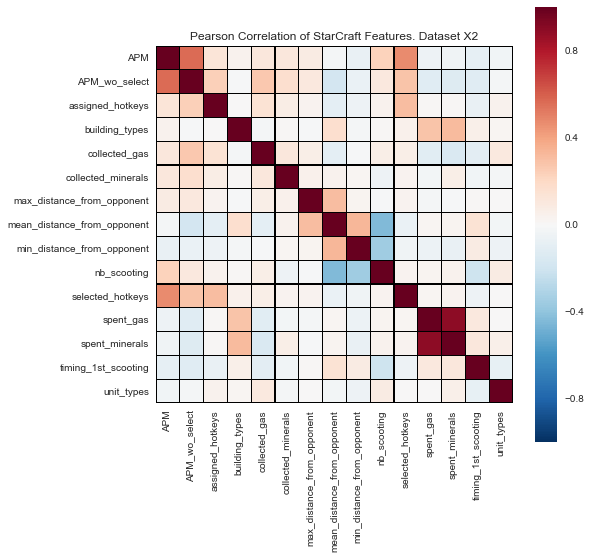

In [14]:

# Set up the matplotlib figure
g, ax2 = plt.subplots(figsize=(8, 8))
plt.title('Pearson Correlation of StarCraft Features. Dataset X2')
# Draw the heatmap using seaborn
sns.heatmap(df_light2.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, linecolor='black')



Forte corrélation entre : 
* APM et APM_wo_selected
* spent_gas and spent_mineral

# Standardization 

In [15]:
X1 = df.iloc[:,1:]
X2 = df_light2

# Data Normalization
from sklearn.preprocessing import StandardScaler
X1_std = StandardScaler().fit_transform(X1)
X2_std = StandardScaler().fit_transform(X2)

# PCA
The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes.
Analyse PCA : principal component analysis, et en amont, choix du nombre de composantes à conserver via Explained Variance

In [16]:
# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X2_std, axis=0)
cov_mat = np.cov(X2_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

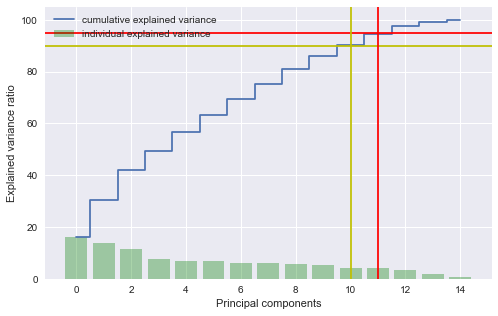

In [17]:
#

Avec la projection, on a perdu l'info explicite de l'importance d'une colonne
On peut choisir de ne conserver que les 11 plus importants nouveaux axes par exemple

In [18]:
from sklearn.decomposition import PCA as sklearnPCA
pca = sklearnPCA(n_components=11)
x_11d = pca.fit_transform(X2_std)

In [19]:
x_11d[0]

array([ 1.38351358, -0.36979979, -0.0883399 ,  0.78674256, -0.65895497,
        0.57093231, -0.41285644,  0.16873403, -0.14022969, -0.07290467,
        0.15658155])

## On a deux jeux de données, 1 à 328 caractéristiques, l'autre à 11

In [20]:
y = df._p1_win_game.as_matrix()

Split les jeux de données (jeu de training (80%) et testing (20%))

In [21]:
# old cross_validation module becomes new model_selection module
from sklearn.model_selection import train_test_split
X1_train, X1_test, y_train, y_test = train_test_split(X1_std, y, test_size=0.2)
X2_train, X2_test, y_train, y_test = train_test_split(x_11d, y, test_size=0.2)


## Les modeles :

1. regression logistique, comme ligne de base
2. SVM : alternative à la LR si dependance non lineaire des features. Difficile a entrainer. Efficace sur hautes dimensions
3. tree ensembles :  Random Forests (Algorithm) and Gradient Boosted Trees. Fonctionnent bien sur categories binaires
et ne nécessite pas de séparation lineaire

In [22]:
# Import de toute une serie d'estimateurs ?
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import Perceptron as PPN
from sklearn.metrics import average_precision_score
#import xgboost
# une methode pour evaluer la precision des modeles
def accuracy(y_true,y_pred):
    # NumPy interpretes True and False as 1. and 0.
    return np.mean(y_true == y_pred)

In [23]:
#KFold : pour diviser les données : évite notamment l'overfitting
#from sklearn.cross_validation  import KFold
from sklearn.model_selection import KFold
#** arguments sous la forme de dico
#X : les donnees
#y : les resultats
#clf_class : un type de classifier : par exemple l'estimateur SVC

def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    #KFold : len(y)?
    # nombre de portions:3, et regroupement des données identiques avant decoupage
    # kf = KFold(len(y),n_folds=3,shuffle=True)
    kf = KFold(n_splits=3)
    # copie la DataFrame des resultats
    y_pred = y.copy()
    
    # Iterate through folds
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # un classifier est un exemple d'estimator, un objet python qui implemente les 
        # methodes .fit(X,y) et predict(T) 
        # Initialize a classifier with keyword arguments
        clf = clf_class(**kwargs)
        # le classifier apprend du modele grace au jeu d'entrainement
        clf.fit(X_train,y_train)
        # puis predit de nouvelles valeurs via le jeu de test
        y_pred[test_index] = clf.predict(X_test)
    return y_pred
# la fonction renvoie les resultats prédits pour le jeu de test (prochaine etape : evaluer l'erreur de la prediction)

In [24]:
# Test des differents modeles
# Plus grande precision : Logistic Regression LR
print "Logistic Regression:"
print "%.3f" % accuracy(y, run_cv(X2_std,y,LR))
print "Gradient Boosting Classifier"
print "%.3f" % accuracy(y, run_cv(X2_std,y,GBC))
#print "XGB Classifier"
#print "%.3f" % accuracy(y, run_cv(X2_std,y,XGB))
print "Support vector machines:"
print "%.3f" % accuracy(y, run_cv(X2_std,y,SVC))
print "Random forest:"
print "%.3f" % accuracy(y, run_cv(X2_std,y,RF))
print "K-nearest-neighbors:"
print "%.3f" % accuracy(y, run_cv(X2_std,y,KNN))

Logistic Regression:
0.676
Gradient Boosting Classifier
0.687
Support vector machines:
0.687
Random forest:
0.651
K-nearest-neighbors:
0.627


En moyenne, ** perte de  4 %  de précision ** pour une grande diminution de la dimensionnalité (328 -> 15).
Peut être utile dans les phases d'optimisation des algorithmes, le SVM notamment, présentant un mauvais scaling 

# Optimisation des algorithmes prédictifs 
## Logistic Regression

In [25]:
# Logistic Regression

y_LR_pred=[]
# Set regularization parameter
for i, C in enumerate((100, 1, 0.01)):
    # turn down tolerance for short training time
    clf_l0_LR = LR(C=C, penalty='l1', tol=0.001)
    clf_l1_LR = LR(C=C, penalty='l1', tol=0.01)
    clf_l2_LR = LR(C=C, penalty='l2', tol=0.01)
    clf_l0_LR.fit(X2_train, y_train)
    clf_l1_LR.fit(X2_train, y_train)
    clf_l2_LR.fit(X2_train, y_train)
    y_LR_pred.append(clf_l0_LR.predict(X2_test))
    y_LR_pred.append(clf_l1_LR.predict(X2_test))
    y_LR_pred.append(clf_l2_LR.predict(X2_test))
acc_LR=[]
for y_pred in y_LR_pred:
    acc_LR.append(accuracy(y_test, y_pred))
acc_LR.index(max(acc_LR))
# meilleur jeu = LR(C=0.01, penalty='l1', tol=0.001)

8

##  RandomForestClassifier

In [ ]:
acc_RF=[]
for n in range (10, 200, 10 ):
    clf_RF = RF(n_estimators=n)
    clf_RF.fit(X2_train, y_train)
    y_pred = clf_RF.predict(X2_test)
    acc_RF.append(accuracy(y_test, y_pred))
acc_RF.index(max(acc_RF))
# meilleur jeu = RF(n_estimators=140)

14

In [24]:
# Support Vector Machine
#param_grid = [
#  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
# ]

y_SVM_pred=[]
# Set regularization parameter
for i, C in enumerate((10, 1, 0.1)):
    for kernel in ['linear', 'rbf', 'poly']:
        # turn down tolerance for short training time
        clf_SVM = SVC(C=C, kernel=kernel, tol=0.001)
        clf_SVM.fit(X2_train, y_train)
        y_SVM_pred.append(clf_SVM.predict(X2_test))
acc_SVM=[]
for y_pred in y_SVM_pred:
    acc_SVM.append(accuracy(y_test, y_pred))
    
acc_SVM.index(max(acc_SVM))
# meilleur jeu = SVM(C=1, kernel="rbf)

[0.66830751411611411]
[0.66830751411611411, 0.66324019111046761]
[0.66830751411611411, 0.66324019111046761, 0.66903141740263505]
[0.66830751411611411, 0.66324019111046761, 0.66903141740263505, 0.66830751411611411]
[0.66830751411611411, 0.66324019111046761, 0.66903141740263505, 0.66830751411611411, 0.6793108440712321]
[0.66830751411611411, 0.66324019111046761, 0.66903141740263505, 0.66830751411611411, 0.6793108440712321, 0.67004488200376433]
[0.66830751411611411, 0.66324019111046761, 0.66903141740263505, 0.66830751411611411, 0.6793108440712321, 0.67004488200376433, 0.66830751411611411]
[0.66830751411611411, 0.66324019111046761, 0.66903141740263505, 0.66830751411611411, 0.6793108440712321, 0.67004488200376433, 0.66830751411611411, 0.67178224989141455]
[0.66830751411611411, 0.66324019111046761, 0.66903141740263505, 0.66830751411611411, 0.6793108440712321, 0.67004488200376433, 0.66830751411611411, 0.67178224989141455, 0.66903141740263505]


4

# Test final

In [25]:
# Test des differents modeles
# Plus grande precision : Logistic Regression LR
print "Logistic Regression:"
print "%.3f" % accuracy(y, run_cv(X1_std,y,LR, C=0.01, penalty='l1', tol=0.001))
print "Gradient Boosting Classifier"
print "%.3f" % accuracy(y, run_cv(X1_std,y,GBC))
#print "XGB Classifier"
#print "%.3f" % accuracy(y, run_cv(X2_std,y,XGB))
print "Support vector machines:"
print "%.3f" % accuracy(y, run_cv(X1_std,y,SVC,C=1,kernel="rbf"))
print "Random forest:"
print "%.3f" % accuracy(y, run_cv(X1_std,y,RF,n_estimators=140))
print "K-nearest-neighbors:"
print "%.3f" % accuracy(y, run_cv(X1_std,y,KNN))

Logistic Regression:
0.738
Gradient Boosting Classifier
0.720
Support vector machines:
0.751
Random forest:
0.732
K-nearest-neighbors:
0.644


## Apprentissage non supervisé : K-Means

In [24]:
X2.head()

,APM,APM_wo_select,assigned_hotkeys,building_types,collected_gas,collected_minerals,max_distance_from_opponent,mean_distance_from_opponent,min_distance_from_opponent,nb_scooting,selected_hotkeys,spent_gas,spent_minerals,timing_1st_scooting,unit_types
0,-52.514968,-24.194918,-21,1,-98.407317,3178.767457,8.921409,13.573083,2.755987,-25,-396,1025,2725,-41.638376,0
1,47.431682,13.239911,9,-2,591.851395,6956.071907,-3.092666,-1.339119,3.575096,-9,-173,-2300,-7575,-48.495400,-1
2,-155.331871,-13.846281,-1,5,-484.647238,2750.713222,1.934465,11.663239,2.601839,-117,2,-125,-2000,-313.573512,1
3,136.910425,38.996989,1,1,1706.586960,-2021.543155,-2.190440,-35.552794,-102.610951,24,-76,2125,-2675,117.110752,4
4,-31.537314,28.962773,0,2,-1274.017014,-3840.025920,0.077156,-43.765192,1.478506,62,14,-1225,-1000,-471.465512,2


In [25]:
x = X2.columns.values.tolist()

y = df._p1_win_game.as_matrix()
x

['APM',
 'APM_wo_select',
 'assigned_hotkeys',
 'building_types',
 'collected_gas',
 'collected_minerals',
 'max_distance_from_opponent',
 'mean_distance_from_opponent',
 'min_distance_from_opponent',
 'nb_scooting',
 'selected_hotkeys',
 'spent_gas',
 'spent_minerals',
 'timing_1st_scooting',
 'unit_types']

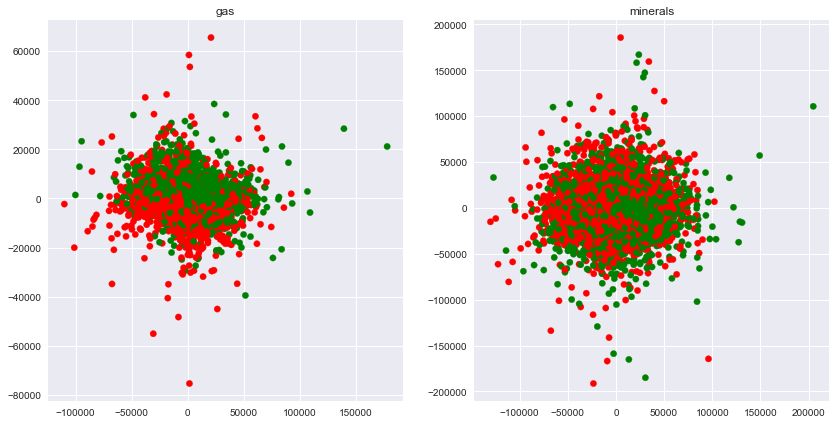

In [26]:

# Set the size of the plot
plt.figure(figsize=(14,7))
 
# Create a colormap
colormap = np.array(['red', 'green'])
 
# Plot gas
plt.subplot(1, 2, 1)
plt.scatter(X2.spent_gas, X2.collected_gas, c=colormap[y], s=40)
plt.title('gas')

# Plot minerals
plt.subplot(1, 2, 2)
plt.scatter(X2.spent_minerals, X2.collected_minerals, c=colormap[y], s=40)
plt.title('minerals')

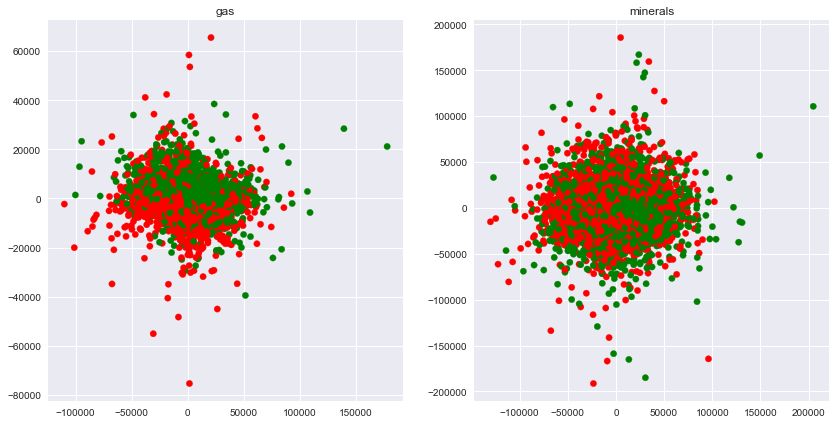

In [27]:
# Set the size of the plot
plt.figure(figsize=(14,7))
 
# Create a colormap
colormap = np.array(['red', 'green', 'blue'])
 
# Plot gas
plt.subplot(1, 2, 1)
plt.scatter(X2.spent_gas, X2.collected_gas, c=colormap[y], s=40)
plt.title('gas')

# Plot minerals
plt.subplot(1, 2, 2)
plt.scatter(X2.spent_minerals, X2.collected_minerals, c=colormap[y], s=40)
plt.title('minerals')

Feature ranking:
1. APM_wo_select (0.128539)
2. APM (0.101680)
3. assigned_hotkeys (0.096927)
4. max_distance_from_opponent (0.093769)
5. mean_distance_from_opponent (0.090215)
6. collected_gas (0.086459)
7. nb_scooting (0.083485)
8. min_distance_from_opponent (0.081498)
9. building_types (0.079871)
10. collected_minerals (0.079430)


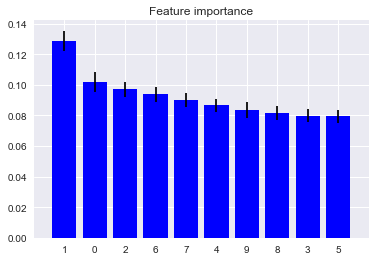

In [28]:
#RF : RandomForestClassifier
forest = RF(n_estimators=140)
forest_fit = forest.fit(X2_train, y_train)
forest_prediction = forest_fit.predict(X2_test)

# renvoie un array avec les importances relatives des 10 premieres caracteristiques
importances = forest_fit.feature_importances_[:10]

# numpy.std : Returns the standard deviation, a measure of the spread of a distribution
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# Renvoie un tableau des indices dans l'ordre où ils seraient après un tri
indices = np.argsort(importances)[::-1]

#Print the feature ranking
print("Feature ranking:")
features = [x for y, x in sorted(zip(importances, X2.columns.values), reverse=True)]

for f in range(10):
    print("%d. %s (%f)" % (f+1, features[f], importances[indices[f]]))
    
#plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices], yerr=std[indices], color="b", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1,10])
plt.show()


In [32]:
y = df._p1_win_game.as_matrix()





Feature ranking:
1. feature 1 (0.295902)
2. feature 2 (0.208351)
3. feature 0 (0.177632)
4. feature 3 (0.047121)
5. feature 6 (0.046303)
6. feature 8 (0.046013)
7. feature 7 (0.045575)
8. feature 4 (0.044614)
9. feature 9 (0.044577)
10. feature 5 (0.043912)


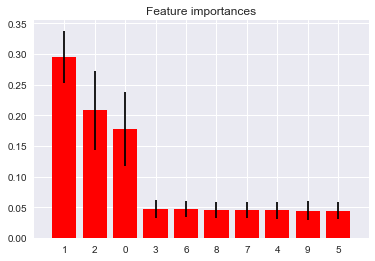

In [30]:

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

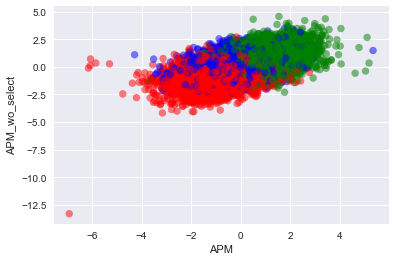

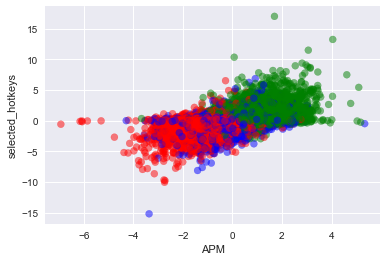

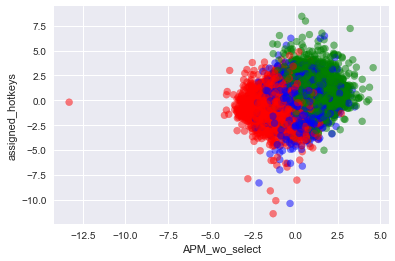

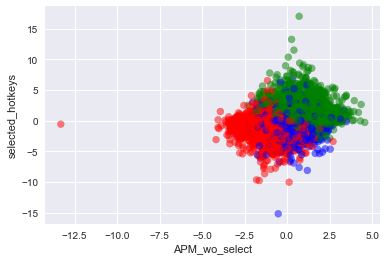

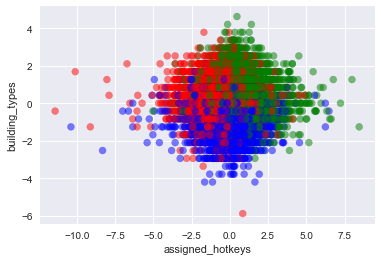

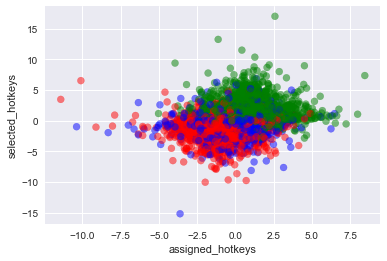

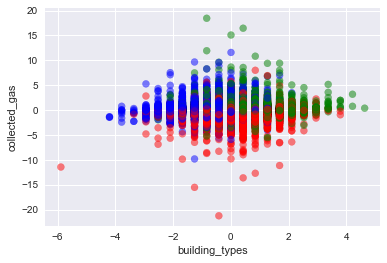

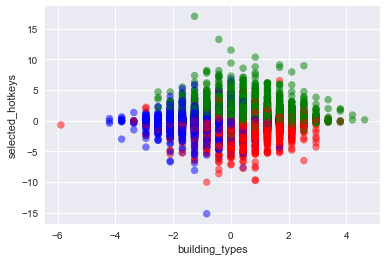

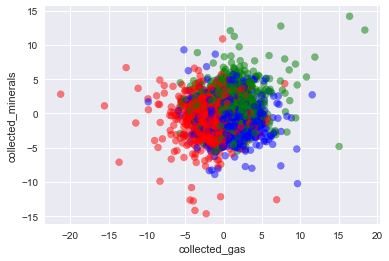

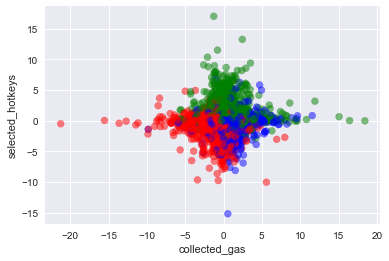

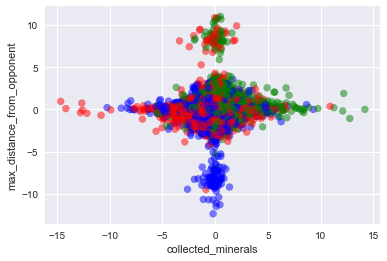

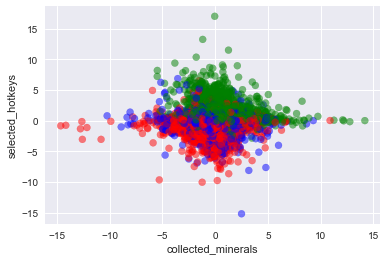

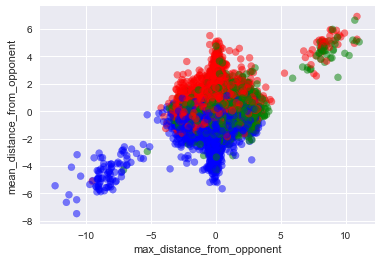

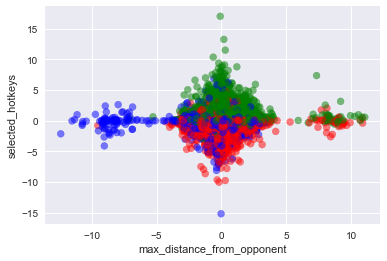

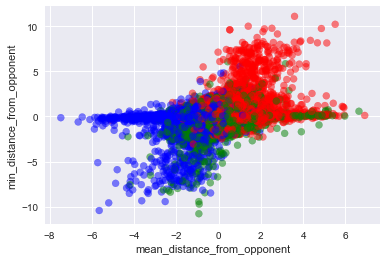

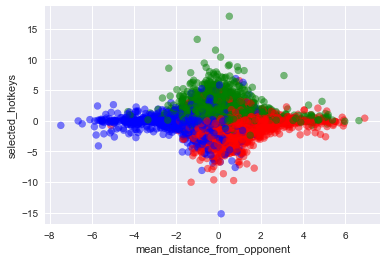

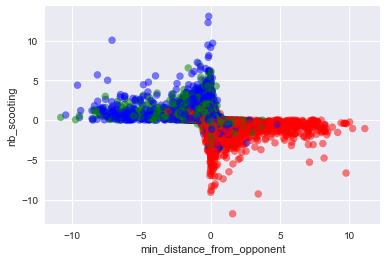

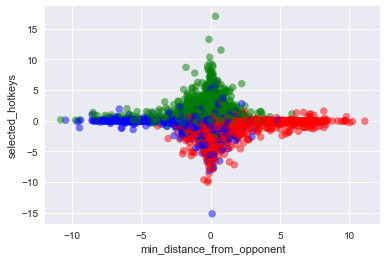

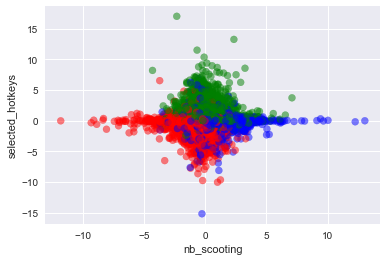

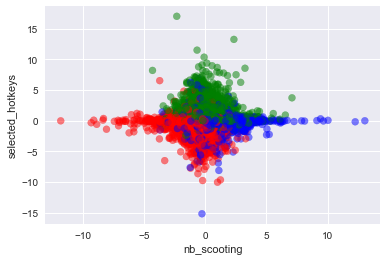

In [31]:
from sklearn.cluster import KMeans 

# Set a 2 KMeans clustering
kmeans = KMeans(n_clusters=3, init='k-means++')
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(X2_std)
# Define our own color map
LABEL_COLOR_MAP = {0 : 'r',1 : 'g',2 : 'b', 3:'black', 4:'brown'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]
for i in range(10):
    for j in [i+1,10]:
        # Plot the scatter digram
        plt.scatter(X2_std[:,i],X2_std[:,j], c= label_color, label='Class 1',alpha=0.5) 
        plt.xlabel(X2.columns.values[i])
        plt.ylabel(X2.columns.values[j])
        plt.show()